In [1]:
import s3fs
import boto3
import time

from PIL import Image
import numpy as np
import hashlib
import io
import json
import csv
import gc
from tqdm import tqdm
import pandas as pd
import os

import torch
from torchvision.transforms import v2
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [2]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



In [4]:
def read_zoom_in():
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv('ZOOMIN.csv')
    del df['Unnamed: 0']
    df['label'] = [8 if x == 5 else x for x in df['label']]
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42,stratify=df['label'])
    train_x, test_x, train_y, test_y =  train_x[:4000], test_x[:1000], train_y[:4000], test_y[:1000]
    return np.array(train_x), np.array(test_x), np.array(train_y), np.array(test_y)

def read_csv_file():
    df = pd.read_csv('compcars-angle.csv')
    del df['Unnamed: 0']
    train_x, test_x, train_y, test_y = train_test_split(df['img_path'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
    train_x, test_x, train_y, test_y = train_x[:12000], test_x[:3661], train_y[:12000], test_y[:3661]
    train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
    train_x = np.concatenate((train_x, train_x_2))
    train_y = np.concatenate((train_y, train_y_2))
    test_x = np.concatenate((test_x, test_x_2))
    test_y = np.concatenate((test_y, test_y_2))
    return train_x, test_x, train_y, test_y


In [5]:
# def total_data():
#     with open('front.json', 'r') as file:
#         front = json.load(file)
#     with open('rear.json', 'r') as file:
#         rear = json.load(file)
#     with open('side_lr.json', 'r') as file:
#         side = json.load(file)
#     with open('rear_lr.json', 'r') as file:
#         rear_lr = json.load(file)
#     with open('front_lr.json', 'r') as file:
#         front_lr = json.load(file)
#     new_data = front
#     new_data.update(rear)
#     new_data.update(side)
#     new_data.update(rear_lr)
#     new_data.update(front_lr)
#     x = list(new_data.keys())
#     y = list(new_data.values())
#     y = [2 if x == 6 else x for x in y]
#     y = [3 if x == 7 else x for x in y]
#     y = [4 if x == 8 else x for x in y]
#     y = [5 if x == 9 else x for x in y]
#     y = [6 if x == 10 else x for x in y]
#     y = [7 if x == 11 else x for x in y]
#     y = [8 if x == 13 else x for x in y]
        
#     train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
#     train_x_2, test_x_2, train_y_2, test_y_2 = read_zoom_in()
#     train_x = np.concatenate((train_x, train_x_2))
#     train_y = np.concatenate((train_y, train_y_2))
#     test_x = np.concatenate((test_x, test_x_2))
#     test_y = np.concatenate((test_y, test_y_2))
#     return train_x, test_x,train_y,test_y

In [6]:
total_data()

(array(['datasets/data/image/75/1665/2012/d8c5c93b08fa00.jpg',
        'datasets/data/image/75/1669/2010/5b453f3c34a98e.jpg',
        'datasets/data/image/106/1313/2008/6d3472369fd19e.jpg', ...,
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Air intake/a2f711f11d7439.jpg',
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Air intake/ad121f35e0f9eb.jpg',
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Air intake/a221b1d8f71a18.jpg'],
       dtype=object),
 array(['datasets/data/image/88/1416/2012/d022fec4373b36.jpg',
        'datasets/data/image/157/1914/2011/73510792645a26.jpg',
        'datasets/data/image/95/915/2013/5607d87148a45e.jpg', ...,
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Air intake/cf1b98350c2052.jpg',
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Air intake/4626b72af387fd.jpg',
        'dpgos-osdata-boaz-beukers-sandbox/compcars/Car parts/External/Ai

In [6]:
def preprocess_image(image_bytes, byte=True):
    # Open the image as bytes
    if byte is True:
        image = Image.open(io.BytesIO(image_bytes))
    if byte is False:
        image = Image.open(image_bytes)
    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(image_paths: list, batch_size: int,
                                 bucket: str, boto_s3: boto3.client("s3"), 
                                 s3fs_: s3fs.S3FileSystem(), target_size=(256, 256)):
    image_tensors = []
    for i in tqdm(range(0, len(image_paths), batch_size), total=len(image_paths)//batch_size, desc='Processing Images'):
        batch_image_paths = image_paths[i:i + batch_size]
        batch_image_tensors = []
        for ad_image in batch_image_paths:
            if ad_image.lower().startswith("S3-PATH"):
                image_path = "/".join(ad_image.split("/")[1:])
                s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
                image_bytes = s3_object['Body'].read()
                image_tensor = preprocess_image(image_bytes,True)
                batch_image_tensors.append(image_tensor)
            if os.path.isfile(ad_image) and ad_image.lower().startswith("datasets/"):
                image_tensor = preprocess_image(ad_image,False)
                batch_image_tensors.append(image_tensor)
        # Resize or crop images to the target size before stacking
        batch_image_tensors_resized = [transforms.functional.resize(image, target_size) for image in batch_image_tensors]
        image_tensors.append(torch.stack(batch_image_tensors_resized))

    # Concatenate processed batches
    processed_image_tensors = torch.cat(image_tensors, dim=0)

    # Display the shape and dtype of the tensor
    print("Tensor Shape:", processed_image_tensors.shape)
    print("Tensor Dtype:", processed_image_tensors.dtype)

    return processed_image_tensors

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, images, targets, num_classes):
        self.images = images
        self.targets = targets
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # Convert target label to one-hot encoded tensor
        one_hot_target = torch.zeros(self.num_classes)
        one_hot_target[target] = 1

        return image, one_hot_target

def dataloader(train_x, train_y, test_x, test_y, num_classes):
    train_images, val_images, train_targets, val_targets = train_test_split(train_x, train_y, test_size=0.3, random_state=42,stratify=train_y)

    train_dataset = CustomDataset(train_images, train_targets, num_classes)
    val_dataset = CustomDataset(val_images, val_targets, num_classes)
    
    test_dataset = CustomDataset(test_x, test_y, num_classes)

    train_batch_size = 32
    val_batch_size = 32
    test_batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=val_batch_size)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader, val_loader, test_loader


In [8]:
def train_trainedResNet(epochs, train_loader, val_loader):
    start_time = time.time()

    model = resnet50(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False   

    model.fc = nn.Sequential(
        nn.Linear(2048, 9)  # Output layer with 6 units for multi-class classification
    ).to(device)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
    optimizer = optim.Adam(model.fc.parameters())

    num_epochs = epochs
    train_losses = []
    validation_losses = []

    best_validation_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets).to(device)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_loss = 0.0
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, targets).to(device)
                train_loss += val_loss.item()

        train_loss /= len(val_loader)
        validation_loss = val_loss.item()

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {validation_loss}')

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training set')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss ResNet50')
    plt.legend()
    plt.savefig('training_validation_figure.png')
    plt.show()

    torch.save(best_model_state, 'model_resnet50_angle.pth')
    end_time = time.time()
    print("Time taken for training:", end_time - start_time, "seconds")
    return best_model_state, model


In [9]:
def test_ResNet(best_model_state, model, test_loader):
    start_time = time.time()
    model.load_state_dict(best_model_state)
    model.eval()

    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs)

    predictions = torch.cat(predictions, dim=0).to(device)

    _, predicted_labels = torch.max(predictions, 1)  # Get the index of the maximum value along the second dimension (class dimension)

    result = predicted_labels.tolist()
    end_time = time.time()
    print("Time taken for testing:", end_time - start_time, "seconds")
    return result


In [23]:
# def show_matrix(test_y,result,filename=None):
#     print(classification_report(test_y, result))
#     cm = confusion_matrix(test_y, result)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['front','rear','side','front-side','rear-side','zoom-in'])
#     disp.plot()
#     if filename:
#         plt.savefig(filename)
#     else:
#         plt.show()
def show_matrix(test_y_svm,y_pred,filename=None):
    print(classification_report(test_y_svm, y_pred))
    cm = confusion_matrix(test_y_svm, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['front','rear','front-left','front-right','rear-right','rear-left','side-left','side-right','zoom-in'])
    disp.plot(xticks_rotation=45)
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

In [ ]:
#train_x, test_x, train_y, test_y = read_csv_file()
train_x, test_x, train_y, test_y = total_data()

gc.collect()

im = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)

im_test = process_duplicates_image_ids(image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
        boto_s3=boto3_s3,
        s3fs_=s3fs_)

Processing Images:   0%|          | 0/147 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Processing Images: 148it [19:36,  7.95s/it]                         


Tensor Shape: torch.Size([14789, 3, 256, 256])
Tensor Dtype: torch.float32


Processing Images: 57it [06:02,  6.36s/it]                        


Tensor Shape: torch.Size([5624, 3, 256, 256])
Tensor Dtype: torch.float32


#(0 - front, 1 - rear, 2 - side, 3 - front-side, 4 - rear-side, 5- zoomin)

In [30]:
def main_trainedResNet():
#     train_x, test_x, train_y, test_y = read_csv_file()
#     gc.collect()

#     im = process_duplicates_image_ids(image_paths=train_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
#             boto_s3=boto3_s3,
#             s3fs_=s3fs_)

#     im_test = process_duplicates_image_ids(image_paths=test_x,batch_size=100,bucket="dpgos-osdata-boaz-beukers-sandbox",
#             boto_s3=boto3_s3,
#             s3fs_=s3fs_)
#     for i in range(5):
    train_loader,val_loader,test_loader = dataloader(im,train_y,im_test,test_y,9)
    best_model,model = train_trainedResNet(100,train_loader,val_loader)
    result = test_ResNet(best_model,model,test_loader)
    show_matrix(test_y,result,filename='ANGLE_trainedResNet_results_testje.png')


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Train Loss: 0.8086833392115805, Val Loss: 0.718437910079956
Epoch 2/100, Train Loss: 0.6847361135397027, Val Loss: 0.6244025230407715
Epoch 3/100, Train Loss: 0.6857184967119917, Val Loss: 0.6266829371452332
Epoch 4/100, Train Loss: 0.6690431668175211, Val Loss: 0.5130818486213684
Epoch 5/100, Train Loss: 0.6421275061669109, Val Loss: 0.6527158617973328
Epoch 6/100, Train Loss: 0.6154087048640354, Val Loss: 0.47086724638938904
Epoch 7/100, Train Loss: 0.6388170676265689, Val Loss: 0.40958669781684875
Epoch 8/100, Train Loss: 0.6835364900904594, Val Loss: 0.5834422707557678
Epoch 9/100, Train Loss: 0.6278252995057072, Val Loss: 0.4922388195991516
Epoch 10/100, Train Loss: 0.6093712603445534, Val Loss: 0.4491596817970276
Epoch 11/100, Train Loss: 0.5940518561455843, Val Loss: 0.4145973026752472
Epoch 12/100, Train Loss: 0.5929772892444254, Val Loss: 0.37454953789711
Epoch 13/100, Train Loss: 0.5876762907710864, Val Loss: 0.4002079367637634
Epoch 14/100, Train Loss: 0.5875374

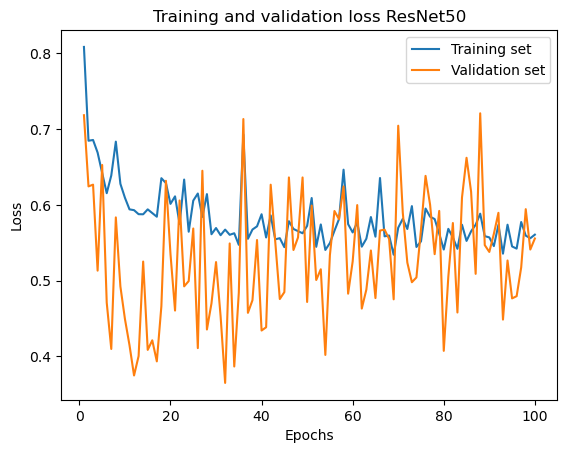

Time taken for training: 5256.263200759888 seconds
Time taken for testing: 18.835487127304077 seconds
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       617
           1       0.96      0.92      0.94       464
           2       0.80      0.62      0.70       964
           3       0.59      0.81      0.68       740
           4       0.58      0.62      0.60       484
           5       0.65      0.60      0.62       570
           6       0.62      0.81      0.70       472
           7       0.59      0.36      0.45       313
           8       0.99      0.99      0.99      1000

    accuracy                           0.76      5624
   macro avg       0.75      0.74      0.73      5624
weighted avg       0.78      0.76      0.76      5624



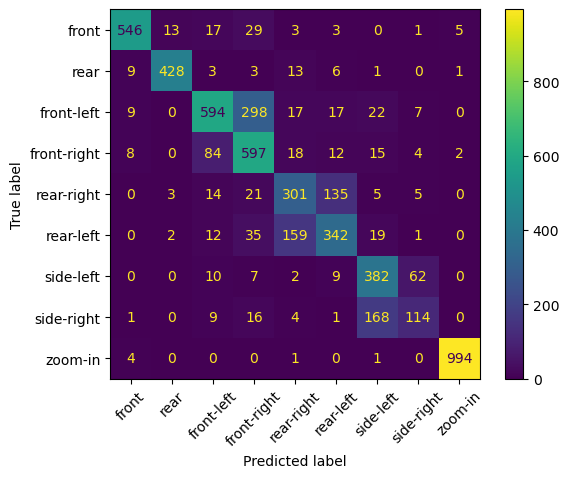

In [31]:
main_trainedResNet()


In [28]:
Counter(train_y)

Counter({8: 4000,
         2: 2251,
         3: 1727,
         0: 1440,
         5: 1329,
         4: 1128,
         6: 1101,
         1: 1083,
         7: 730})